In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Embedding, Flatten, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import scipy.sparse as sp
import joblib
import os
import time
import datetime

In [3]:
# 创建输出目录
os.makedirs('../models/nn_models', exist_ok=True)
os.makedirs('../outputs/visualization/nn_models', exist_ok=True)

# 1 加载预处理好的数据或直接使用之前保存的训练集

In [4]:
try:
    # 尝试加载保存的预处理特征和目标
    preprocessed_X_train = joblib.load('../models/preprocessed_X_train.joblib')
    preprocessed_X_test = joblib.load('../models/preprocessed_X_test.joblib')
    y_train = joblib.load('../models/y_train.joblib')
    y_test = joblib.load('../models/y_test.joblib')
    print("已加载预处理好的特征矩阵和目标值")
except:
    # 如果没有保存的预处理数据，加载原始数据并应用预处理
    print("未找到预处理数据，加载原始数据...")
    
    # 加载数据
    df = pd.read_csv('../datasets/walmart_preprocessed.csv')
    
    # 分割特征和目标
    X = df.drop('Purchase', axis=1)
    y = df['Purchase']
    
    # 定义数值和分类特征
    numerical_features = ['Occupation', 'Stay_Years', 'Product_Category', 
                         'City_Code', 'Gender_Code', 'Total_User_Purchase', 
                         'Purchase_Count', 'Avg_User_Purchase', 'Avg_Category_Purchase',
                         'Product_Purchase_Var', 'City_Occupation_Mean',
                         'Avg_Transaction_Value', 'Product_Category_Squared',
                         'Occupation_Squared', 'Recency_Score']
    
    categorical_features = ['Gender', 'Age', 'City_Category', 'Marital_Status', 
                           'Gender_City', 'Age_City', 'Age_Marital', 'RFM_Score', 
                           'Preferred_Category']
    
    # 检查特征是否在数据集中
    numerical_features = [col for col in numerical_features if col in X.columns]
    categorical_features = [col for col in categorical_features if col in X.columns]
    
    # 创建预处理管道
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )
    
    # 分割训练集和测试集
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # 应用预处理
    print("应用预处理转换...")
    preprocessed_X_train = preprocessor.fit_transform(X_train)
    preprocessed_X_test = preprocessor.transform(X_test)
    
    # 保存预处理后的数据以供后续使用
    joblib.dump(preprocessed_X_train, '../models/preprocessed_X_train.joblib')
    joblib.dump(preprocessed_X_test, '../models/preprocessed_X_test.joblib')
    joblib.dump(y_train, '../models/y_train.joblib')
    joblib.dump(y_test, '../models/y_test.joblib')
    joblib.dump(preprocessor, '../models/preprocessor.joblib')

未找到预处理数据，加载原始数据...
应用预处理转换...


# 2 选择样本用于训练神经网络

In [5]:
print("准备神经网络训练数据...")
sample_size = 100000  # 或任何您想要的样本大小

if len(y_train) > sample_size:
    # 随机选择样本
    sample_indices = np.random.choice(len(y_train), sample_size, replace=False)
    
    # 根据是否是稀疏矩阵选择不同的处理方式
    if sp.issparse(preprocessed_X_train):
        # 稀疏矩阵需要转换为密集矩阵
        X_train_nn = preprocessed_X_train[sample_indices].toarray()
        X_test_nn = preprocessed_X_test.toarray()
    else:
        X_train_nn = preprocessed_X_train[sample_indices]
        X_test_nn = preprocessed_X_test
        
    # 获取对应的目标值
    if isinstance(y_train, pd.Series):
        y_train_nn = y_train.iloc[sample_indices].values
    else:
        y_train_nn = y_train[sample_indices]
else:
    # 如果样本数少于要求，使用全部数据
    if sp.issparse(preprocessed_X_train):
        X_train_nn = preprocessed_X_train.toarray()
        X_test_nn = preprocessed_X_test.toarray()
    else:
        X_train_nn = preprocessed_X_train
        X_test_nn = preprocessed_X_test
        
    if isinstance(y_train, pd.Series):
        y_train_nn = y_train.values
    else:
        y_train_nn = y_train

print(f"神经网络训练数据: X形状={X_train_nn.shape}, y长度={len(y_train_nn)}")

准备神经网络训练数据...
神经网络训练数据: X形状=(100000, 23), y长度=100000


# 3 构建基本神经网络模型

In [6]:
print("构建基本神经网络模型...")

def build_basic_nn():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train_nn.shape[1],)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

构建基本神经网络模型...


# 4 构建更深层的神经网络模型

In [7]:
def build_deep_nn():
    model = Sequential([
        Dense(256, activation='relu', input_shape=(X_train_nn.shape[1],)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    
    # 学习率衰减
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=1000,
        decay_rate=0.9
    )
    
    model.compile(
        optimizer=Adam(learning_rate=lr_schedule),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# 5 定义回调函数

In [8]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

callbacks = [early_stopping, reduce_lr]

# 6 训练基本模型

In [9]:
print("训练基本神经网络模型...")
basic_model = build_basic_nn()

start_time = time.time()
history_basic = basic_model.fit(
    X_train_nn, y_train_nn,
    epochs=50,
    batch_size=256,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)
basic_train_time = time.time() - start_time

训练基本神经网络模型...
Epoch 1/50
313/313 [==============================] - 1s 2ms/step - loss: 108504072.0000 - mae: 9167.8135 - val_loss: 102658248.0000 - val_mae: 8932.4404 - lr: 0.0010
Epoch 2/50
313/313 [==============================] - 1s 2ms/step - loss: 85751336.0000 - mae: 8197.6836 - val_loss: 63944800.0000 - val_mae: 7140.4434 - lr: 0.0010
Epoch 3/50
313/313 [==============================] - 1s 2ms/step - loss: 45680160.0000 - mae: 6012.2485 - val_loss: 31126844.0000 - val_mae: 4918.1455 - lr: 0.0010
Epoch 4/50
313/313 [==============================] - 1s 2ms/step - loss: 16006734.0000 - mae: 3217.6482 - val_loss: 10006723.0000 - val_mae: 2473.9836 - lr: 0.0010
Epoch 5/50
313/313 [==============================] - 1s 2ms/step - loss: 10027600.0000 - mae: 2451.6780 - val_loss: 8742205.0000 - val_mae: 2271.9341 - lr: 0.0010
Epoch 6/50
313/313 [==============================] - 1s 2ms/step - loss: 9501178.0000 - mae: 2352.6038 - val_loss: 8395691.0000 - val_mae: 2192.2124 - lr: 0.00

# 7 训练深度模型

In [10]:
print("训练更深层神经网络模型...")
deep_model = build_deep_nn()

start_time = time.time()
history_deep = deep_model.fit(
    X_train_nn, y_train_nn,
    epochs=100,
    batch_size=256,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)
deep_train_time = time.time()

训练更深层神经网络模型...
Epoch 1/100
313/313 [==============================] - 2s 4ms/step - loss: 107967936.0000 - mae: 9154.4062 - val_loss: 100950488.0000 - val_mae: 8888.4795 - lr: 9.6766e-04
Epoch 2/100
313/313 [==============================] - 1s 3ms/step - loss: 81330344.0000 - mae: 8011.5503 - val_loss: 49837324.0000 - val_mae: 6168.3286 - lr: 9.3627e-04
Epoch 3/100
313/313 [==============================] - 1s 3ms/step - loss: 36612816.0000 - mae: 5232.3325 - val_loss: 21677530.0000 - val_mae: 3880.8391 - lr: 9.0590e-04
Epoch 4/100
313/313 [==============================] - 1s 3ms/step - loss: 18351894.0000 - mae: 3484.0100 - val_loss: 11748406.0000 - val_mae: 2639.8384 - lr: 8.7651e-04
Epoch 5/100
313/313 [==============================] - 1s 3ms/step - loss: 12070112.0000 - mae: 2685.1423 - val_loss: 10837723.0000 - val_mae: 2557.2876 - lr: 8.4808e-04
Epoch 6/100
313/313 [==============================] - 1s 3ms/step - loss: 11283757.0000 - mae: 2583.4895 - val_loss: 10043300.0000 -

# 8 评估模型

In [11]:
print("评估模型...")
# 基本模型评估
y_pred_basic = basic_model.predict(X_test_nn).flatten()
r2_basic = r2_score(y_test, y_pred_basic)
rmse_basic = np.sqrt(mean_squared_error(y_test, y_pred_basic))
mae_basic = mean_absolute_error(y_test, y_pred_basic)

评估模型...
3438/3438 [==============================] - 3s 820us/step


In [12]:
print(f"基本神经网络模型评估结果:")
print(f"  R²: {r2_basic:.4f}")
print(f"  RMSE: {rmse_basic:.2f}")
print(f"  MAE: {mae_basic:.2f}")
print(f"  训练时间: {basic_train_time:.2f}秒")

基本神经网络模型评估结果:
  R²: 0.6675
  RMSE: 2890.32
  MAE: 2139.20
  训练时间: 26.00秒


In [13]:
# 深度模型评估
y_pred_deep = deep_model.predict(X_test_nn).flatten()
r2_deep = r2_score(y_test, y_pred_deep)
rmse_deep = np.sqrt(mean_squared_error(y_test, y_pred_deep))
mae_deep = mean_absolute_error(y_test, y_pred_deep)

3438/3438 [==============================] - 2s 711us/step


In [14]:
print(f"\n深度神经网络模型评估结果:")
print(f"  R²: {r2_deep:.4f}")
print(f"  RMSE: {rmse_deep:.2f}")
print(f"  MAE: {mae_deep:.2f}")
print(f"  训练时间: {deep_train_time:.2f}秒")


深度神经网络模型评估结果:
  R²: 0.6688
  RMSE: 2884.59
  MAE: 2137.32
  训练时间: 1744421505.15秒


# 9 可视化训练历史

In [16]:
import matplotlib as mpl

mpl.rcParams['font.family'] = 'SimHei'  # 或其他支持中文的字体
mpl.rcParams['axes.unicode_minus'] = False  # 解决负号'-'显示为方块的问题

C:\Users\avawa\AppData\Local\Temp\ipykernel_23356\2699190473.py:48: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from current font.
  plt.tight_layout()
C:\Users\avawa\AppData\Local\Temp\ipykernel_23356\2699190473.py:49: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from current font.
  plt.savefig('../outputs/visualization/nn_models/nn_model_comparison.png')
c:\Users\avawa\.conda\envs\mixrec\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


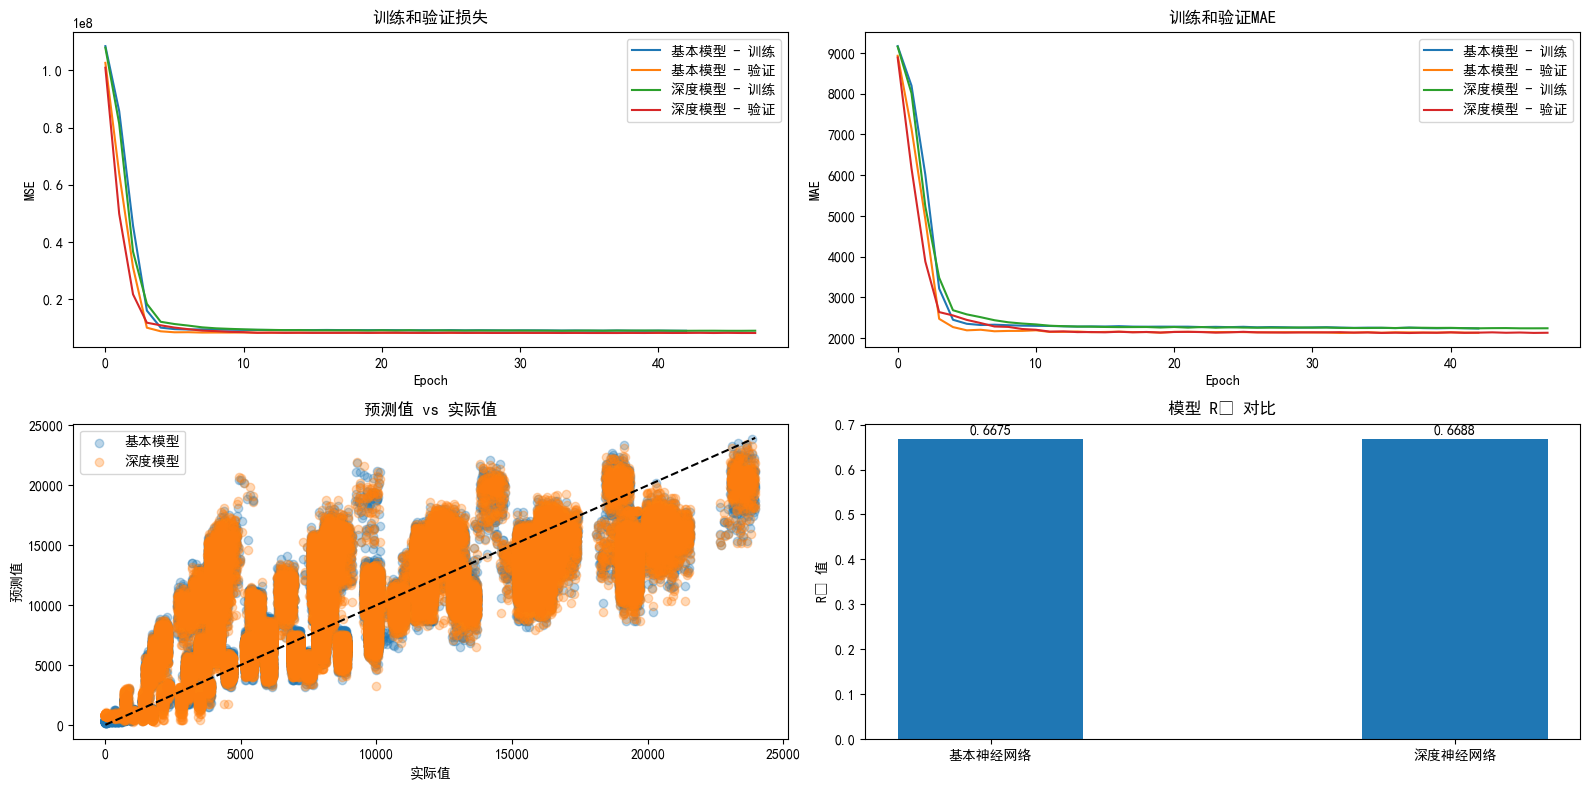

In [17]:
plt.figure(figsize=(16, 8))

# 损失曲线
plt.subplot(2, 2, 1)
plt.plot(history_basic.history['loss'], label='基本模型 - 训练')
plt.plot(history_basic.history['val_loss'], label='基本模型 - 验证')
plt.plot(history_deep.history['loss'], label='深度模型 - 训练')
plt.plot(history_deep.history['val_loss'], label='深度模型 - 验证')
plt.title('训练和验证损失')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

# MAE曲线
plt.subplot(2, 2, 2)
plt.plot(history_basic.history['mae'], label='基本模型 - 训练')
plt.plot(history_basic.history['val_mae'], label='基本模型 - 验证')
plt.plot(history_deep.history['mae'], label='深度模型 - 训练')
plt.plot(history_deep.history['val_mae'], label='深度模型 - 验证')
plt.title('训练和验证MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# 预测散点图
plt.subplot(2, 2, 3)
plt.scatter(y_test, y_pred_basic, alpha=0.3, label='基本模型')
plt.scatter(y_test, y_pred_deep, alpha=0.3, label='深度模型')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('实际值')
plt.ylabel('预测值')
plt.title('预测值 vs 实际值')
plt.legend()

# R²和RMSE对比条形图
plt.subplot(2, 2, 4)
models = ['基本神经网络', '深度神经网络']
r2_values = [r2_basic, r2_deep]
x = range(len(models))
plt.bar(x, r2_values, width=0.4)
plt.xticks(x, models)
plt.ylabel('R² 值')
plt.title('模型 R² 对比')

for i, v in enumerate(r2_values):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')

plt.tight_layout()
plt.savefig('../outputs/visualization/nn_models/nn_model_comparison.png')
plt.show()

# 10 保存模型

In [18]:
basic_model.save('../models/nn_models/basic_nn_model')
deep_model.save('../models/nn_models/deep_nn_model')

# 保存模型评估结果
model_results = pd.DataFrame({
    'Model': ['Basic NN', 'Deep NN'],
    'R2': [r2_basic, r2_deep],
    'RMSE': [rmse_basic, rmse_deep],
    'MAE': [mae_basic, mae_deep],
    'Training Time (s)': [basic_train_time, deep_train_time]
})

model_results.to_csv('../outputs/nn_model_comparison.csv', index=False)

INFO:tensorflow:Assets written to: ../models/nn_models/basic_nn_model\assets


INFO:tensorflow:Assets written to: ../models/nn_models/basic_nn_model\assets


INFO:tensorflow:Assets written to: ../models/nn_models/deep_nn_model\assets


INFO:tensorflow:Assets written to: ../models/nn_models/deep_nn_model\assets


## 11 记录训练信息

In [19]:
nn_model_info = {
    'sample_size': len(X_train_nn),
    'feature_count': X_train_nn.shape[1],
    'basic_model': {
        'r2': r2_basic,
        'rmse': rmse_basic,
        'mae': mae_basic,
        'train_time': basic_train_time
    },
    'deep_model': {
        'r2': r2_deep,
        'rmse': rmse_deep,
        'mae': mae_deep,
        'train_time': deep_train_time
    },
    'training_date': datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

import json
with open('../models/nn_models/nn_model_info.json', 'w') as f:
    json.dump(nn_model_info, f, indent=4)

print("\n训练完成！模型已保存到 '../models/nn_models/' 目录")


训练完成！模型已保存到 '../models/nn_models/' 目录
